In [1]:
import keras
from keras import layers

In [2]:
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

In [3]:
# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [4]:
#Let's also create a separate encoder model:

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [5]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [6]:
#Now let's train our autoencoder to reconstruct MNIST digits.

#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
#Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [9]:
# Now let's train our autoencoder for 50 epochs:

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 5s 16ms/step - loss: 0.2752 - val_loss: 0.1881
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1709 - val_loss: 0.1541
Epoch 3/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1445 - val_loss: 0.1338
Epoch 4/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1285 - val_loss: 0.1213
Epoch 5/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1183 - val_loss: 0.1130
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1110 - val_loss: 0.1067
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1057 - val_loss: 0.1024
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1019 - val_loss: 0.0992
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0993 - val_loss: 0.0969
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0974 - val_lo

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [10]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

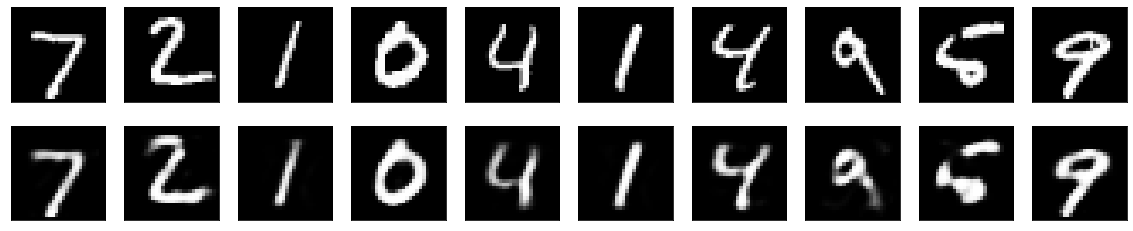

In [11]:
# Use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [12]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [13]:
#Let's also create a separate encoder model:

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [14]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [15]:
#Now let's train our autoencoder to reconstruct MNIST digits.

#First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [16]:
#Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [17]:
# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [18]:
# Now let's train our autoencoder for 50 epochs:

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 5s 13ms/step - loss: 0.2844 - val_loss: 0.1936
Epoch 2/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1766 - val_loss: 0.1606
Epoch 3/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1524 - val_loss: 0.1429
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1381 - val_loss: 0.1312
Epoch 5/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1285 - val_loss: 0.1233
Epoch 6/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1216 - val_loss: 0.1174
Epoch 7/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1166 - val_loss: 0.1133
Epoch 8/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1130 - val_loss: 0.1103
Epoch 9/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1105 - val_loss: 0.1083
Epoch 10/50
235/235 [==============================] - 3s 12ms/step - loss: 0.1088 - val_lo

In [19]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

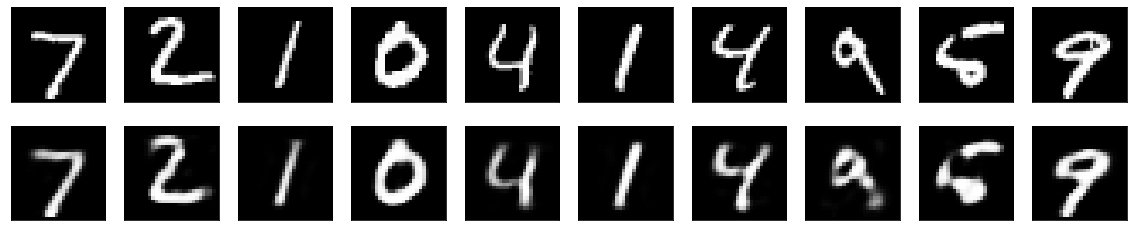

In [20]:
# Use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [21]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [23]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 5s 19ms/step - loss: 0.0815 - val_loss: 0.0802
Epoch 2/100
235/235 [==============================] - 4s 18ms/step - loss: 0.0805 - val_loss: 0.0804
Epoch 3/100
235/235 [==============================] - 4s 18ms/step - loss: 0.0806 - val_loss: 0.0803
Epoch 4/100
235/235 [==============================] - 4s 18ms/step - loss: 0.0806 - val_loss: 0.0804
Epoch 5/100
235/235 [==============================] - 5s 21ms/step - loss: 0.0806 - val_loss: 0.0805
Epoch 6/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0806 - val_loss: 0.0807
Epoch 7/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0806 - val_loss: 0.0804
Epoch 8/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0805 - val_loss: 0.0803
Epoch 9/100
235/235 [==============================] - 4s 17ms/step - loss: 0.0805 - val_loss: 0.0802
Epoch 10/100
235/235 [==============================] - 4s 17ms/step - loss: 0.080

In [26]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

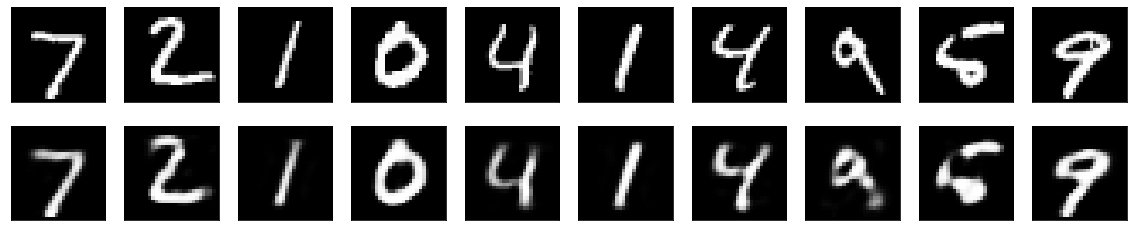

In [25]:
# Use Matplotlib 
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()